In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt
from matplotlib import colors

from unagi import config
from unagi import hsc
from unagi import plotting
from unagi.task import hsc_psf

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

import pyimfit

pyimfit.__file__

cutout_edge = fits.open('results_resized/Galaxy6Closer_i.fits')

# Science image
i_img = cutout_edge[1].data

# Variance map; both are 2-D numpy array
i_var = cutout_edge[3].data




/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get table list from /Users/isabelm/Desktop/SpringJP/unagi-master/unagi/data/pdr2_wide/pdr2_wide_tables.fits


(812, 812) 406.0 406.0
# Mean sky background: 0.000912
# Uncertainty of sky background: 0.047314


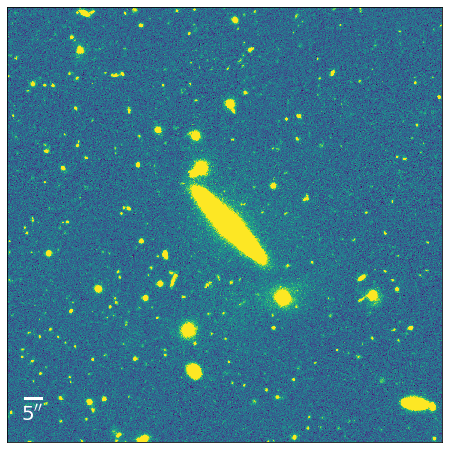

In [3]:
_ = plotting.display_single(i_img)

# We also want to know the size of the image and the pixel coordinate for the galaxy center
img_shape = i_img.shape

cen_x, cen_y = img_shape[0] / 2., img_shape[1] / 2.

print(img_shape, cen_x, cen_y)

# Also need to know the central flux level
cen_flux = i_img[int(cen_x), int(cen_y)]

from photutils import make_source_mask
from astropy.stats import sigma_clipped_stats

mask = make_source_mask(i_img, nsigma=1.5, npixels=4, dilate_size=15)
bkg_avg, bkg_med, bkg_std = sigma_clipped_stats(i_img, sigma=2.5, mask=mask)

print("# Mean sky background: {:f}".format(bkg_med))
print("# Uncertainty of sky background: {:f}".format(bkg_std))

i_msk = fits.open('goodmasks/Mask6.fits')[0].data




In [4]:
# Define a coordinate using the center of the galaxy
ra_obj, dec_obj = 181.09158, -0.71935
coord = SkyCoord(ra_obj, dec_obj, frame='icrs', unit='deg')

# This command will download PSF image from HSC archive. 
# It will take a few seconds, so it is better to download all the necessary ones at once.
psf_model = hsc_psf(coord, filters='i', archive=pdr2, prefix='edgeon_testnew')

i_psf = psf_model[0].data


# Retrieving coadd PSF model in filter: i


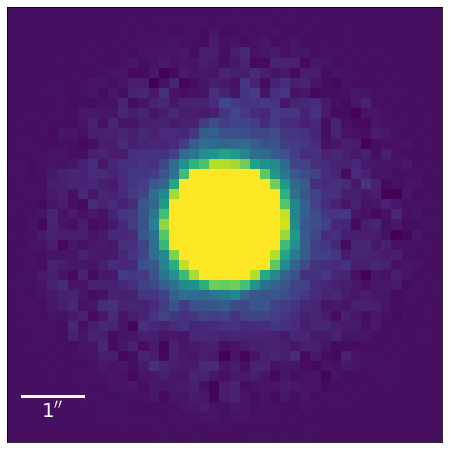

In [5]:
# PSF looks boring. It is basically a Gaussian function with some small deviations. 
# Basically, it is what a star looks like on HSC image
_ = plotting.display_single(i_psf, contrast=0.1, scale_bar_length=1.0)

['PA', 'L_0', 'h', 'n', 'z_0']
['I_sky']


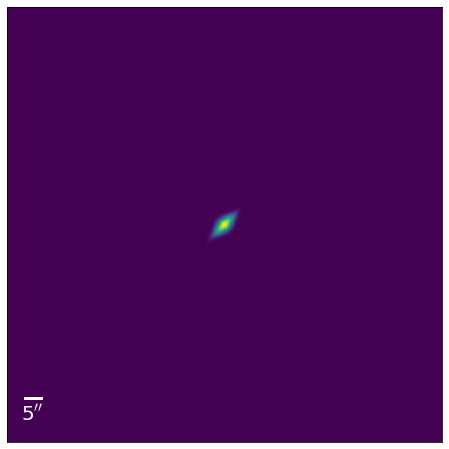

In [6]:
# Here are what these parameters named in `imfit`
print(pyimfit.imageFunctionDict['EdgeOnDisk'])
print(pyimfit.imageFunctionDict['FlatSky'])


# Let call this model `edgeonly`
edgeonly_desc = pyimfit.SimpleModelDescription()

# Define the limits on the central-coordinate X0 and Y0 as +/-10 pixels relative to initial values
edgeonly_desc.x0.setValue(cen_x, [cen_x - 10, cen_x + 10])
edgeonly_desc.y0.setValue(cen_y, [cen_y - 10, cen_y + 10])

# Creates an Edge-on Exponential component
edgedisk = pyimfit.make_imfit_function('EdgeOnDisk')
# Set initial values, lower and upper limits of each parameters
# You can pretty much eyeball the PA of the edge on disk
edgedisk.PA.setValue(135, [0, 180])
# The L_0 should not be that different from the central flux level
edgedisk.L_0.setValue(cen_flux, [cen_flux / 5.0, cen_flux * 20.0])
edgedisk.h.setValue(5, [0.2, 100])
edgedisk.z_0.setValue(2, [0.2, 50])
edgedisk.n.setValue(1, [0.5, 50])

edgeonly_desc.addFunction(edgedisk)

# We want to pass the PSF image to the model object now
edgeonly = pyimfit.Imfit(edgeonly_desc, i_psf)

# And we can see what's our initial guess look like
model_ini = edgeonly.getModelImage(shape=img_shape)

# Not crazy compared to the real galaxy
_ = plotting.display_single(model_ini, scale='linear', contrast=1.0)

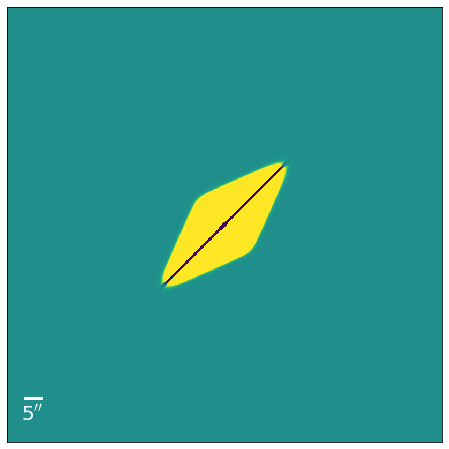

In [7]:
# Just for demonstration, we can also get a version without PSF convolution
edgeonly_nopsf = pyimfit.Imfit(edgeonly_desc) 

# And we can generate a model without PSF convolution and check the difference
model_nopsf = edgeonly_nopsf.getModelImage(shape=img_shape)

# Not crazy compared to the real galaxy
_ = plotting.display_single(model_ini - model_nopsf, contrast=0.5)

# Basically, PSF "moves" some flux from the high-intensity region to the fainter part of the galaxy.

In [8]:
edgeonly.loadData(i_img, mask=i_msk, error=i_var, error_type="variance")


Exception: Failure in ModelObject::FinalSetupForFitting().

In [9]:
solver = 'NM'

edgeonly_result = edgeonly.doFit(solver=solver)

Exception: No data for fit! (Supply it via loadData() or fit() methods)

In [ ]:
if edgeonly_result.fitConverged:
    # If the fitting result converged (meaning the algorithm thinks it finds the best solution)
    # Show some fitting statistics
    print("# Chi2 satistics: {:f}".format(edgeonly_result.fitStat))
    # For a perfect model reduced chi2 value should be very close to 1.0
    print("# Reduced Chi2 satistics: {:f}".format(edgeonly_result.fitStatReduced))
    # AIC and BIC
    print("# AIC statistics: {:f}".format(edgeonly_result.aic))
    print("# BIC statistics: {:f}".format(edgeonly_result.bic))
    print("\n # Best fit parameter values:")
    if solver == 'LM':
        for name, val, err in zip(
            edgeonly.numberedParameterNames, edgeonly_result.params, edgeonly_result.paramErrs): 
            print("   {:7s}: {:f}+/-{:f}".format(name, val, err))
    else:
        for name, val in zip(edgeonly.numberedParameterNames, edgeonly_result.params): 
            print("   {:7s}: {:f}".format(name, val))
else:
    print("# Model is not converged! Please try again!")
    
    


In [ ]:
# Now let's see the model image
edgeonly_mod = edgeonly.getModelImage()

# Model image contains no noise, and the "background" value is determined by the numerical accuracy of some C++ code
# used in `imfit`. Something like 1E-10..this will cause problem when we try to visualize the model image directly
# We can create a fake "sky" image to add to it

i_sky = np.random.normal(loc=bkg_avg, scale=bkg_std, size=img_shape)

_ = plotting.display_single(edgeonly_mod + i_sky, contrast=0.15)

# The model and model parameters do not look crazy

In [ ]:
# Now let's see the residual patterns
edgeonly_res = i_img - edgeonly_mod

# This is the relative model error information.
# It is (data - model) / error
edgeonly_chi = edgeonly_res * np.sqrt(i_var)

In [ ]:
def create_circular_mask(img, center=None, radius=None):
    """Create a circular mask to apply to an image.
    
    Based on https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    """
    h, w = img.shape
    
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [ ]:
# Clear out the inner region
cen_mask = create_circular_mask(i_img, radius=120)

galaxy_residual = edgeonly_chi[cen_mask & (i_msk == 0)]

fig = plt.figure(figsize=(9, 4.5))
fig.subplots_adjust(left=0.0, right=1.0, bottom=0.1, top=0.99, wspace=0.0, hspace=0.0)

# Highlight the residual pattern around the galaxy
ax1 = fig.add_subplot(121)
ax1.grid(False)

# We use a different colormap to highlight features on the residual map. 
# We can use blue for negative values and red for positive values
ax1 = plotting.display_single(
    edgeonly_chi[int(cen_x - 120):int(cen_x + 120), int(cen_y - 120):int(cen_y + 120)], 
    cmap='RdBu_r', stretch='arcsinh', zmin=-0.15, zmax=0.15, ax=ax1,
    scale_bar_color='k', scale_bar_y_offset=0.3)
ax1.imshow(
    i_msk.astype('float')[int(cen_x - 120):int(cen_x + 120), int(cen_y - 120):int(cen_y + 120)], 
    origin='lower', interpolation='none', cmap='Greys', alpha=0.1)

# Show the distribution of residual levels
ax2 = fig.add_subplot(122)
ax2.axvline(0.0, linestyle='--', color='k', alpha=0.9)
_ = ax2.hist(galaxy_residual, bins=100, log=True, histtype='stepfilled',
             density=True, alpha=0.5, edgecolor='k')
ax2.set_yticklabels([])

ax2.set_xlabel(r'$\rm (Data - Model) / \sigma$', fontsize=25)